# PyTorch Computer Vision

* See reference notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb 
* See reference online book - https://www.learnpytorch.io/03_pytorch_computer_vision/

## 0. Computer vision libaries in PyTorch

* [`torchvision`](https://www.learnpytorch.io/03_pytorch_computer_vision/) - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cpu
0.19.0+cpu


## 1. Getting a dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets - https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST 

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    download=True, # should we download the data?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform=None # how do we want to transform the labels/target?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Check input and output shapes of data

In [7]:
# Check the shape of the image
print(f"Image shape: {image.shape} -> [color channel, height, width]")
print(f"Image Label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color channel, height, width]
Image Label: Ankle boot


### 1.1 Visualizing our data

Image shape: torch.Size([1, 28, 28])


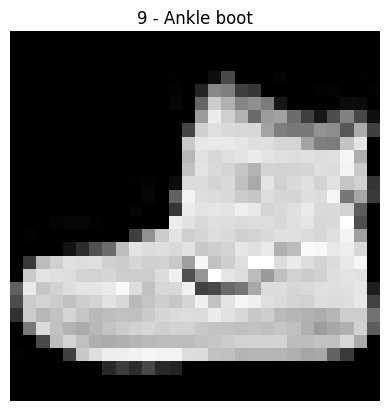

In [8]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap='gray')
plt.title(str(label) + " - " + class_names[label])
plt.axis('off');

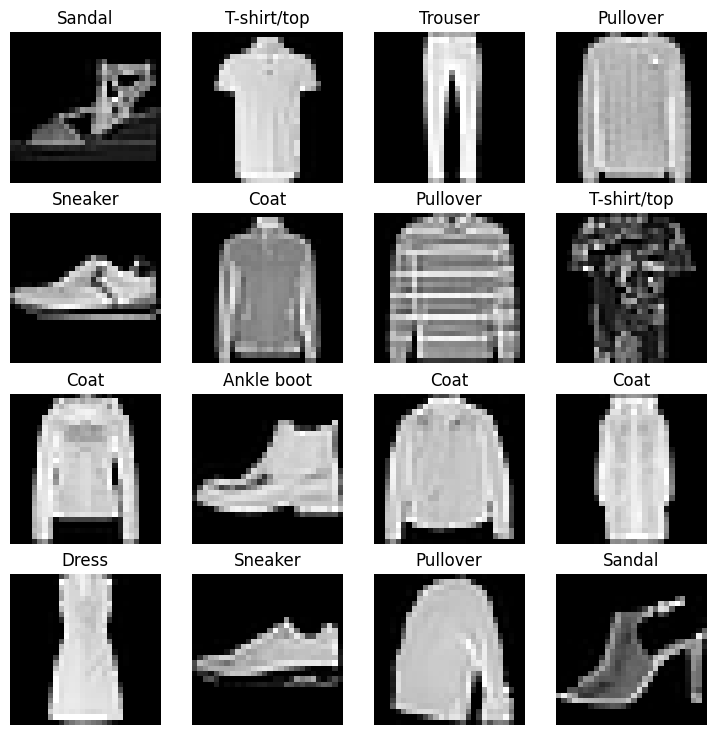

In [9]:
# Plot more images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, columns = 4, 4
for i in range(1, rows*columns+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

Do you think these items of clothing (images) could be modelled with pure linear lines? Or do you think we'll need non-linearities?

In [10]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32). 
2. It gives our neural network more chances to update its gradients per epoch.

For more on mini-batches, see here: https://youtu.be/l4lSUAcvHFs

In [11]:
# Turn train dataset into DatLoader
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [12]:
# Let's check out what we've created
print(f"DataLoaders: {train_dataloader}, {test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: <torch.utils.data.dataloader.DataLoader object at 0x00000260C2616910>, <torch.utils.data.dataloader.DataLoader object at 0x00000260EC8E9D30>
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [13]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 1, label size: torch.Size([])


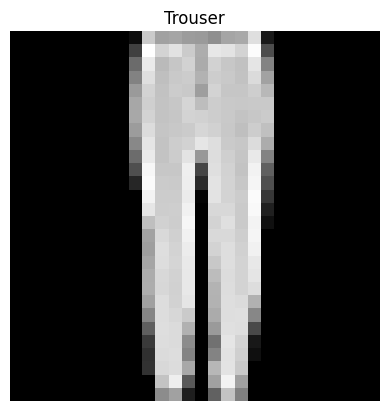

In [14]:
# Show a sample
# torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a basline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [15]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [16]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [30]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape= 28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1, 1, 28, 28])
output = model_0(dummy_x)
print(f"Shape before flattening: {dummy_x.shape}")
print(f"Shape after flattening: {output.shape}")
output

Shape before flattening: torch.Size([1, 1, 28, 28])
Shape after flattening: torch.Size([1, 10])


tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [19]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem, let's use accruacy as our evaluation metric

In [20]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [31]:
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs 

In [32]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [23]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start_time, end_time, device="CPU")

Train time on CPU: 0.000 seconds


1.1799999999340116e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

**Note:** Because we are computing on *batches*, the optimizer will update the model's parameters once *per batch* rather than once per epoch.

In [33]:
# Import tqdm for progress bars
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
NUM_EPOCHS = 3

# Create training and test loop

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"Epoch {epoch+1}\n-------------------------------")
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backward pass
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader to get average train loss
    train_loss /= len(train_dataloader)


    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test) # forward pass  
            test_loss += loss_fn(test_pred, y_test) # accumulate test loss
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1)) # accumulate test accuracy
        
        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test accuracy average per batch
        test_acc /= len(test_dataloader)

    # Print out the final test loss and test accuracy
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate total training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                            train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 33%|███▎      | 1/3 [00:03<00:06,  3.33s/it]


Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch 2
-------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 67%|██████▋   | 2/3 [00:06<00:03,  3.26s/it]


Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch 3
-------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 3/3 [00:09<00:00,  3.25s/it]


Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 9.762 seconds


In [27]:
next(model_0.parameters()).device

device(type='cpu')

## 4. Make predictions and get Model 0 results

In [38]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    # Set the model to evaluation mode
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return{"model_name": model.__class__.__name__, # only works when model was created with a class
           "model_loss": loss.item(),
           "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model = model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 767.64it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}